## Пример построения  двухслойной нейронной сети на numpy 

строим нейросеть с одним скрытым слоем и перебираем гиперпараметры:
- ```neuron_numb``` - количество нейронов в скрытом слое
- ```learning_rate``` - скорость обучения
- ```num_epochs``` - количество эпох

результат предсказания на тренировочной и тестовой выборке собираем в единую сводную таблицу, сортируем её по значению метрики ```accuracy``` и смотрим, при каких гиперпараметрах метрика на отложенной выборке покажет лучший результат 

работаем с датасетом ```load_digits``` - это набор изображений рукописных цифр от 0 до 9. Соответственно, учимся предсказывать число на изображению.

_____

импортируем библиотеки:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm, notebook
notebook.tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

загружаем данные и подготавливаем их:

(1797, 64)


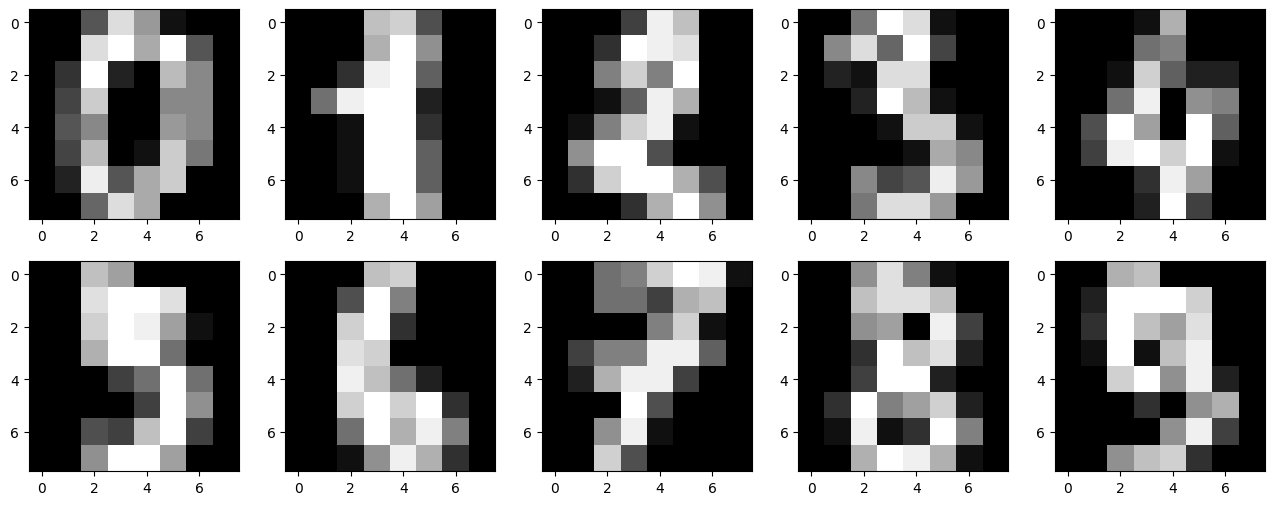

In [2]:
# Подготовка тренировочных данных
X, y = load_digits(return_X_y=True)
print(X.shape) # расскоментируйте, чтобы размер данных

# репрезентация данных
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8, 8]), cmap='gray')

In [3]:
def to_one_hot(Y):
    """функция преобразует вектор меток Y в матрицу "one-hot" кодирования"""
    
    n_col = np.max(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1
    return binarized


# формирование входных данных
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# формирование выходных данных(результатов)
y = y.flatten()
y = to_one_hot(y)
display(y, y.shape)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

(1797, 10)

In [4]:
# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train.shape, X_test.shape

((1203, 64), (594, 64))

вот основной код функции, которая проводит формирует нейросеть по переданным гиперпараметрам, прооводит обучение, собирает и считает метрику и, если необходимо, отриосвывает график обучения модели:

In [5]:
def sigmoid(x):
    """вычисление сигмоид функции"""
    x = np.clip(x, a_min=-500, a_max=500)
    return 1 / (1 + np.exp(-x))


def sigmoid_deriv(x):
    """вычисление производной от сигмоид функции"""
    return sigmoid(x) * (1 - sigmoid(x))


def neural_network_training(X_train, y_train, X_test, y_test, neuron_numb=15, 
                            learning_rate=0.001, num_epochs=1000, random=0, get_plot=False):
    """
    Обучение нейронной сети
    neuron_numb - скрытый слой
    learning_rate - скорость обучения
    num_epochs - количество итераций
    """
    
    np.random.seed(random)

    w0 = np.random.random((64, neuron_numb))  # для входного слоя - 64 входа и neuron_numb выходов
    w1 = np.random.random((neuron_numb, 10))  # для внутреннего слоя - neuron_numb входов и 10 выходов

    # массивы для ошибок и точности на тренировочных и тестовых данных
    train_errors, train_metrics = [], []
    test_errors, test_metrics = [], []

    # процесс обучения
    for i in range(num_epochs):
        # прямое распространение(feed forward) на тренировочных данных
        train_layer0 = X_train
        train_layer1 = sigmoid(np.dot(train_layer0, w0))
        train_layer2 = sigmoid(np.dot(train_layer1, w1))

        # обратное распространение (back propagation) на тренировочных данных
        train_layer2_error = train_layer2 - y_train  # производная функции потерь
        train_layer2_grad = train_layer2_error * sigmoid_deriv(train_layer2)

        train_layer1_error = train_layer2_grad.dot(w1.T)
        train_layer1_grad = train_layer1_error * sigmoid_deriv(train_layer1)

        w1 -= train_layer1.T.dot(train_layer2_grad) * learning_rate
        w0 -= train_layer0.T.dot(train_layer1_grad) * learning_rate

        # ошибка модели на тренировочных данных
        train_error = np.mean(np.abs(train_layer2_error))
        train_errors.append(train_error)

        # точность на тренировочных данных
        train_preds = np.argmax(train_layer2, axis=1)
        train_labels = np.argmax(y_train, axis=1)
        train_accuracy = (train_preds == train_labels).sum() * 100 / len(train_labels)
        train_metrics.append(train_accuracy)

        # прямое распространение(feed forward) на тестовых данных
        test_layer0 = X_test
        test_layer1 = sigmoid(np.dot(test_layer0, w0))
        test_layer2 = sigmoid(np.dot(test_layer1, w1))

        # ошибка модели на тестовых данных
        test_error = np.mean(np.abs(test_layer2 - y_test))
        test_errors.append(test_error)

        # точность на тестовых данных
        test_preds = np.argmax(test_layer2, axis=1)
        test_labels = np.argmax(y_test, axis=1)
        test_accuracy = (test_preds == test_labels).sum() * 100 / len(test_labels)
        test_metrics.append(test_accuracy)
    
    # рисуем
    if get_plot:
        fig, ax = plt.subplots(nrows=2, figsize=(15, 9))
        fig.suptitle('Диаграмма точности в зависимости от обучения', fontsize=16, fontweight='bold')
        ax[0].plot(train_errors, c='red', label='Ошибка (тренировочные данные)')
        ax[0].plot(test_errors, c='blue', label='Ошибка (тестовые данные)')
        ax[0].set_xlabel('Обучение')
        ax[0].set_ylabel('Ошибка')
        ax[0].minorticks_on()
        ax[0].grid(which='major', linewidth=.5)
        ax[0].grid(which='minor', linewidth=.25, linestyle='--')
        ax[0].legend()

        ax[1].plot(train_metrics, c='red', label='Точность (тренировочные данные)')
        ax[1].plot(test_metrics, c='blue', label='Точность (тестовые данные)')
        ax[1].set_xlabel('Количество итераций')
        ax[1].set_ylabel('Accuracy (%)')
        ax[1].minorticks_on()
        ax[1].grid(which='major', linewidth=.5)
        ax[1].grid(which='minor', linewidth=.25, linestyle='--')
        ax[1].legend()

        fig.tight_layout()
        
    return train_accuracy, test_accuracy

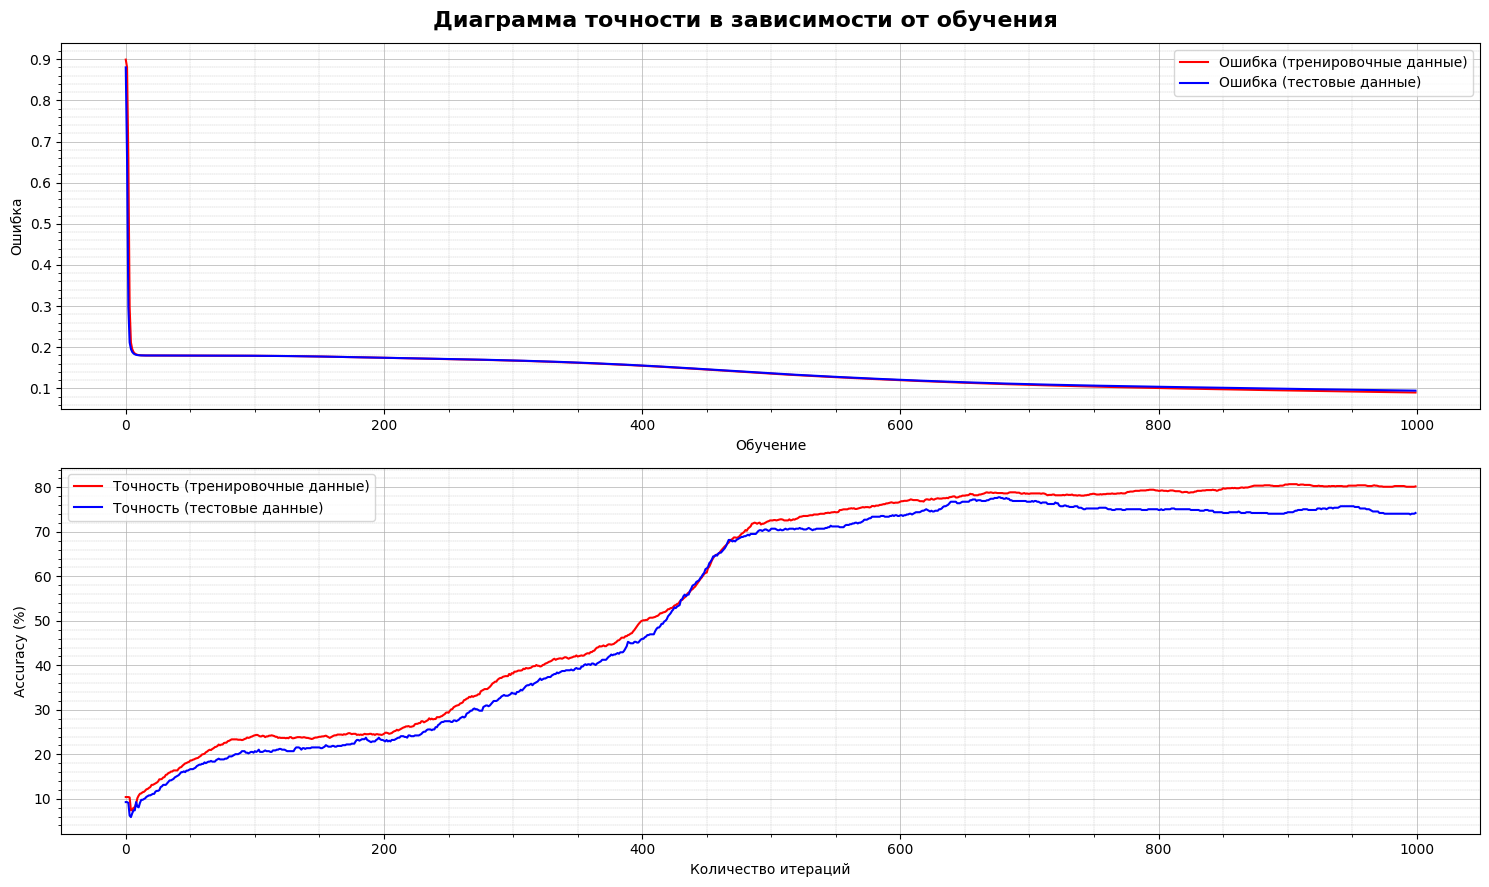

In [6]:
_, _ = neural_network_training(X_train, y_train, X_test, y_test, get_plot=1)

теперь посмотрим, как будет изменяться качество accuracy в зависимости от разных гиперпараметров, собрав значения в единую сводную таблицу:

In [7]:
pivot_table = pd.DataFrame(columns=['learning_rate', 'num_epochs', 
                                    'neuron_numb', 'train_accuracy', 'test_accuracy'])

гиперпараметры переберём следующие:
- ```learning_rate (lr)```: от 0.01 до 0.000001 (включительно) с равномерным распределением по логарифмической шкале
- ```num_epochs (ne)```: от 1 до 1500 (включительно) с шагом 50
- ```neuron_numb (n_numb)```: от 1 до 50 (включительно) с шагом 5

In [8]:
train_accuracy_list, test_accuracy_list = [], []
for lr in notebook.tqdm(np.logspace(-2, -6, num=5)):
    for ne in np.arange(1, 1501, 50):
        for n_numb in np.arange(1, 51, 5):
            train_accuracy, test_accuracy = neural_network_training(X_train, y_train,
                                                                    X_test, y_test,
                                                                    learning_rate=lr,
                                                                    num_epochs=ne,
                                                                    neuron_numb=n_numb)
            pivot_table.loc[len(pivot_table)] = \
                [lr, ne, n_numb, train_accuracy, test_accuracy]
            train_accuracy_list.append(train_accuracy)
            test_accuracy_list.append(test_accuracy)

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
pivot_table.sort_values('test_accuracy', ascending=False)

,learning_rate,num_epochs,neuron_numb,train_accuracy,test_accuracy
249,0.01000,1201.0,46.0,99.916874,96.296296
116,0.01000,551.0,31.0,99.002494,96.296296
196,0.01000,951.0,31.0,99.750623,96.296296
206,0.01000,1001.0,31.0,99.916874,96.296296
209,0.01000,1001.0,46.0,99.916874,96.296296
...,...,...,...,...,...
1016,0.00001,551.0,31.0,7.148795,5.387205
8,0.01000,1.0,41.0,9.725686,5.218855
1006,0.00001,501.0,31.0,5.735661,4.377104
616,0.00010,51.0,31.0,5.569410,3.703704


обучив 1500 моделей видим, что наибольшее влияние на точность имеет количество эпох, а вот скорость обучения на результат сильно не повлияла. Количество скрытых слоёв нужно подбирать экспертно, но оно, конечно, не должно быть сильно ниже количества нейронов в выходном слое, так как малое количество нейронов в скрытом слое будет обобщать классификацию и это может плохо сказаться на общем качестве предсказания.